# Deep Q-learning (DQL) or Deep Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
def model_input(state_size, action_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    actions_logits = tf.placeholder(tf.float32, [None, action_size], name='actions_logits')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, actions_logits, states, next_states, targetQs, is_training

In [9]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [10]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [11]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [12]:
def bn(inputs, training=False):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [13]:
# Generator/Autorencoder/Adv
def G(states, actions_logits, state_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('G', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = tf.concat([h, actions_logits], axis=1)
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        next_states_ = mlp(inputs=h, units=state_size)
        return next_states_

In [14]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions_ = mlp(inputs=h, units=action_size)
        return actions_

In [15]:
def model_loss(actions, actions_logits, states, next_states, targetQs, state_size, action_size, hidden_size, 
               is_training=False):

    next_states_ = G(states=states, actions_logits=actions_logits, hidden_size=hidden_size, 
                     state_size=state_size, is_training=is_training)
    
    gloss = tf.reduce_mean(tf.reduce_sum((next_states - next_states_)**2, axis=1))

    actions_logits_ = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                        is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits_.dtype)
    
    Qs = tf.reduce_max(actions_logits_ * actions_labels, axis=1)
    
    dloss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits_, next_states_, gloss, dloss

In [16]:
def model_opt(gloss, dloss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('G')]
    d_vars = [var for var in t_vars if var.name.startswith('D')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(gloss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(dloss, var_list=d_vars)

    return g_opt, d_opt

In [17]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        (self.actions, self.actions_logits, self.states, self.next_states, self.targetQs, \
         self.is_training) = model_input(state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits_, self.next_states_, self.gloss, self.dloss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size,
            states=self.states, next_states=self.next_states, 
            actions=self.actions, actions_logits=self.actions_logits,
            targetQs=self.targetQs, is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(gloss=self.gloss, dloss=self.dloss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [18]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [19]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [20]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-04         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20             # experience mini-batch size
gamma = 0.99                 # future reward discount

In [21]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)
(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [22]:
# state = env.reset()

# for _ in range(memory_size):
    
#     action = env.action_space.sample()
    
#     next_state, reward, done, _ = env.step(action)
    
#     memory.buffer.append([state, action, next_state, reward, float(done)])
    
#     state = next_state
    
#     if done is True:
#         state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [23]:
def learn(sess, memory, batch_size):
    
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    actions_logits = np.array([each[5] for each in batch])
    
    next_actions_logits_ = sess.run(model.actions_logits_, feed_dict = {model.states: next_states, 
                                                                        model.is_training: False})
    
    nextQs = np.max(next_actions_logits_, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    feed_dict = {model.states: states, model.actions: actions, model.actions_logits: actions_logits,
                 model.next_states: next_states, model.targetQs: targetQs, model.is_training: False}
    
    dloss, _ = sess.run([model.dloss, model.d_opt], feed_dict)
    gloss, _ = sess.run([model.gloss, model.g_opt], feed_dict)
                                                             
    return gloss, dloss

In [24]:
def env_(sess, state, action_logits):
    
    next_state_ = sess.run(model.next_states_, feed_dict={
        model.states: state.reshape([1, -1]), 
        model.actions_logits: action_logits.reshape([1, -1]),
        model.is_training: False})
    
    return next_state_.reshape(-1)

In [25]:
def act(sess, state):
    
    action_logits_ = sess.run(model.actions_logits_, feed_dict={model.states: state.reshape([1, -1]), 
                                                                model.is_training: False})
    
    action = np.argmax(action_logits_, axis=1)[0]
    #print(action)
    
    return action, action_logits_.reshape(-1)

In [26]:
# l = []
# l.append([0, 1])

In [28]:
# l[0][0]

In [29]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    #total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            action, action_logits = act(sess, state)
                
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done), action_logits])
            
            # Explore (Env) or Exploit (Model)
            #total_step += 1
            #explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step)
            explore_p = np.random.normal(0, 1)
            if np.abs(explore_p) < 1e-3:
                print('np.abs(explore_p) < 1e-3:', explore_p)
                next_state = env_(sess, state=state, action_logits=action_logits)
            
            total_reward += reward
            state = next_state

            # Training
            if len(memory.buffer) >= batch_size:
                gloss, dloss = learn(sess, memory, batch_size)
                loss_batch.append([gloss, dloss])
            
            if done is True:
                break
                
        if len(memory.buffer) >= batch_size:
            episode_reward.append(total_reward)

            print('Episode:{}'.format(ep),
                  'meanR:{:.4f}'.format(np.mean(episode_reward)),
                  'R:{}'.format(total_reward),
                  'gloss:{:.4f}'.format(np.mean(loss_batch, axis=0)[0]),
                  'dloss:{:.4f}'.format(np.mean(loss_batch, axis=0)[1]))
            
            # Ploting out
            episode_rewards_list.append([ep, np.mean(episode_reward)])
            rewards_list.append([ep, total_reward])
            loss_list.append([ep, np.mean(loss_batch)])

            # Break episode/epoch loop
            if np.mean(episode_reward) >= 500:
                break
        
        else: print('len(memory.buffer) >= batch_size:', len(memory.buffer), batch_size)
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

len(memory.buffer) >= batch_size: 11 20
Episode:1 meanR:10.0000 R:10.0 gloss:2.8557 dloss:1.0103
Episode:2 meanR:10.0000 R:10.0 gloss:2.8186 dloss:1.0093
Episode:3 meanR:9.6667 R:9.0 gloss:2.6354 dloss:1.0168
Episode:4 meanR:9.2500 R:8.0 gloss:2.3546 dloss:1.0431
Episode:5 meanR:9.2000 R:9.0 gloss:2.2775 dloss:1.0520
Episode:6 meanR:9.5000 R:11.0 gloss:2.0923 dloss:1.0673
Episode:7 meanR:9.2857 R:8.0 gloss:1.9754 dloss:1.0928
Episode:8 meanR:9.3750 R:10.0 gloss:1.7880 dloss:1.1477
Episode:9 meanR:9.4444 R:10.0 gloss:1.5490 dloss:1.1796
Episode:10 meanR:9.6000 R:11.0 gloss:1.2697 dloss:1.2499
Episode:11 meanR:9.4545 R:8.0 gloss:1.2435 dloss:1.3027
Episode:12 meanR:9.4167 R:9.0 gloss:1.0432 dloss:1.3840
Episode:13 meanR:9.3077 R:8.0 gloss:0.8542 dloss:1.4370
Episode:14 meanR:9.3571 R:10.0 gloss:0.7017 dloss:1.4930
Episode:15 meanR:9.3333 R:9.0 gloss:0.6383 dloss:1.5941
Episode:16 meanR:9.3750 R:10.0 gloss:0.5297 dloss:1.6611
Episode:17 meanR:9.3529 R:9.0 gloss:0.4116 dloss:1.8443
Episode

Episode:144 meanR:9.3100 R:10.0 gloss:0.0082 dloss:0.4015
Episode:145 meanR:9.3200 R:10.0 gloss:0.0074 dloss:0.1191
Episode:146 meanR:9.3100 R:9.0 gloss:0.0082 dloss:0.4118
Episode:147 meanR:9.3100 R:9.0 gloss:0.0062 dloss:0.1131
Episode:148 meanR:9.3000 R:9.0 gloss:0.0093 dloss:0.4188
Episode:149 meanR:9.3000 R:9.0 gloss:0.0065 dloss:0.1332
Episode:150 meanR:9.3000 R:9.0 gloss:0.0058 dloss:0.1414
Episode:151 meanR:9.3000 R:10.0 gloss:0.0057 dloss:0.1360
Episode:152 meanR:9.3100 R:9.0 gloss:0.0055 dloss:0.1434
Episode:153 meanR:9.3100 R:10.0 gloss:0.0069 dloss:0.1717
Episode:154 meanR:9.3200 R:9.0 gloss:0.0074 dloss:0.1445
Episode:155 meanR:9.3200 R:9.0 gloss:0.0084 dloss:0.4697
Episode:156 meanR:9.3200 R:9.0 gloss:0.0082 dloss:0.1840
Episode:157 meanR:9.3100 R:9.0 gloss:0.0076 dloss:0.2274
Episode:158 meanR:9.3100 R:10.0 gloss:0.0071 dloss:0.1863
Episode:159 meanR:9.3300 R:10.0 gloss:0.0061 dloss:0.2181
Episode:160 meanR:9.3200 R:8.0 gloss:0.0058 dloss:0.1911
Episode:161 meanR:9.3300 

Episode:282 meanR:36.8100 R:37.0 gloss:0.0178 dloss:4.0766
Episode:283 meanR:36.9900 R:31.0 gloss:0.0196 dloss:3.6306
Episode:284 meanR:37.1400 R:34.0 gloss:0.0166 dloss:3.8672
Episode:285 meanR:37.2800 R:32.0 gloss:0.0184 dloss:3.6829
Episode:286 meanR:37.3400 R:25.0 gloss:0.0193 dloss:3.8507
Episode:287 meanR:37.4600 R:39.0 gloss:0.0189 dloss:3.9034
Episode:288 meanR:37.6000 R:31.0 gloss:0.0185 dloss:3.7183
Episode:289 meanR:37.5600 R:25.0 gloss:0.0183 dloss:3.6685
Episode:290 meanR:37.9000 R:62.0 gloss:0.0175 dloss:3.6862
Episode:291 meanR:37.7000 R:25.0 gloss:0.0169 dloss:3.5687
Episode:292 meanR:37.6200 R:44.0 gloss:0.0155 dloss:3.4735
Episode:293 meanR:37.7500 R:42.0 gloss:0.0164 dloss:3.5756
Episode:294 meanR:37.6500 R:26.0 gloss:0.0154 dloss:3.4243
np.abs(explore_p) < 1e-3: 0.000699807923229033
Episode:295 meanR:37.5700 R:41.0 gloss:0.0161 dloss:3.6069
Episode:296 meanR:37.5200 R:31.0 gloss:0.0166 dloss:3.6999
Episode:297 meanR:37.8900 R:68.0 gloss:0.0164 dloss:3.2935
Episode:2

Episode:419 meanR:21.8800 R:12.0 gloss:0.0315 dloss:63.9724
Episode:420 meanR:21.3500 R:13.0 gloss:0.0427 dloss:53.5035
Episode:421 meanR:21.1100 R:12.0 gloss:0.0402 dloss:57.6283
Episode:422 meanR:20.7800 R:14.0 gloss:0.0371 dloss:43.5733
Episode:423 meanR:20.4600 R:12.0 gloss:0.0343 dloss:37.5606
Episode:424 meanR:20.0900 R:12.0 gloss:0.0344 dloss:27.7401
Episode:425 meanR:19.6300 R:15.0 gloss:0.0377 dloss:33.0568
np.abs(explore_p) < 1e-3: 9.594596764807327e-05
Episode:426 meanR:19.4000 R:11.0 gloss:0.0351 dloss:30.7864
Episode:427 meanR:18.6400 R:11.0 gloss:0.0365 dloss:77.7654
Episode:428 meanR:18.4600 R:14.0 gloss:0.0406 dloss:14.7060
Episode:429 meanR:18.2200 R:12.0 gloss:0.0377 dloss:44.4652
Episode:430 meanR:17.9700 R:13.0 gloss:0.0404 dloss:68.0407
Episode:431 meanR:17.7900 R:18.0 gloss:0.0326 dloss:48.4293
Episode:432 meanR:17.7800 R:19.0 gloss:0.0482 dloss:49.8047
Episode:433 meanR:17.7700 R:20.0 gloss:0.0419 dloss:71.8297
Episode:434 meanR:17.8900 R:36.0 gloss:0.0413 dloss:

Episode:553 meanR:30.4300 R:28.0 gloss:0.0525 dloss:29.1585
Episode:554 meanR:29.9600 R:16.0 gloss:0.0486 dloss:21.7028
Episode:555 meanR:29.6300 R:25.0 gloss:0.0485 dloss:27.4506
Episode:556 meanR:29.5900 R:16.0 gloss:0.0480 dloss:15.4543
Episode:557 meanR:29.5300 R:16.0 gloss:0.0597 dloss:23.1539
Episode:558 meanR:29.3100 R:23.0 gloss:0.0504 dloss:29.0035
Episode:559 meanR:29.2400 R:21.0 gloss:0.0532 dloss:22.7546
Episode:560 meanR:29.2300 R:18.0 gloss:0.0440 dloss:28.4716
Episode:561 meanR:29.0300 R:17.0 gloss:0.0526 dloss:22.4416
np.abs(explore_p) < 1e-3: 0.0006563452183335105
Episode:562 meanR:28.9500 R:20.0 gloss:0.0557 dloss:35.7971
Episode:563 meanR:28.7800 R:19.0 gloss:0.0527 dloss:21.1080
Episode:564 meanR:28.7200 R:24.0 gloss:0.0533 dloss:13.9133
Episode:565 meanR:28.7700 R:21.0 gloss:0.0527 dloss:14.4187
Episode:566 meanR:28.7000 R:22.0 gloss:0.0505 dloss:13.7841
Episode:567 meanR:28.6900 R:16.0 gloss:0.0510 dloss:26.3165
Episode:568 meanR:28.5400 R:17.0 gloss:0.0482 dloss:

Episode:687 meanR:21.8900 R:23.0 gloss:0.0521 dloss:26.1663
Episode:688 meanR:21.7900 R:19.0 gloss:0.0551 dloss:21.5999
Episode:689 meanR:21.9000 R:31.0 gloss:0.0540 dloss:27.5840
Episode:690 meanR:21.9200 R:29.0 gloss:0.0535 dloss:22.1816
Episode:691 meanR:22.0200 R:33.0 gloss:0.0565 dloss:16.0684
Episode:692 meanR:22.0500 R:25.0 gloss:0.0528 dloss:20.7697
Episode:693 meanR:22.1900 R:29.0 gloss:0.0496 dloss:21.0880
Episode:694 meanR:22.2500 R:25.0 gloss:0.0513 dloss:17.1683
Episode:695 meanR:22.2500 R:26.0 gloss:0.0544 dloss:23.3021
Episode:696 meanR:22.2800 R:27.0 gloss:0.0530 dloss:28.7275
Episode:697 meanR:22.6000 R:47.0 gloss:0.0555 dloss:25.6183
Episode:698 meanR:22.8800 R:61.0 gloss:0.0498 dloss:23.9249
Episode:699 meanR:22.9300 R:38.0 gloss:0.0514 dloss:24.3920
Episode:700 meanR:22.9300 R:27.0 gloss:0.0555 dloss:20.7318
Episode:701 meanR:22.8600 R:23.0 gloss:0.0515 dloss:15.4267
Episode:702 meanR:22.8600 R:26.0 gloss:0.0555 dloss:20.7664
Episode:703 meanR:22.8900 R:26.0 gloss:0

Episode:818 meanR:35.1800 R:41.0 gloss:0.0467 dloss:20.9841
Episode:819 meanR:35.2300 R:39.0 gloss:0.0447 dloss:15.9746
Episode:820 meanR:35.3700 R:37.0 gloss:0.0502 dloss:20.1153
Episode:821 meanR:35.8100 R:64.0 gloss:0.0436 dloss:27.8952
Episode:822 meanR:35.8000 R:28.0 gloss:0.0452 dloss:17.0298
Episode:823 meanR:36.0200 R:49.0 gloss:0.0468 dloss:20.9759
np.abs(explore_p) < 1e-3: 0.0002453954263217992
Episode:824 meanR:36.3000 R:49.0 gloss:0.0460 dloss:15.8078
Episode:825 meanR:36.6300 R:55.0 gloss:0.0452 dloss:25.2503
Episode:826 meanR:36.8100 R:45.0 gloss:0.0444 dloss:26.1853
Episode:827 meanR:36.7600 R:35.0 gloss:0.0485 dloss:15.6965
Episode:828 meanR:36.8100 R:33.0 gloss:0.0476 dloss:22.3681
Episode:829 meanR:36.9400 R:53.0 gloss:0.0462 dloss:25.0332
Episode:830 meanR:37.0900 R:37.0 gloss:0.0486 dloss:21.7039
Episode:831 meanR:37.4600 R:72.0 gloss:0.0453 dloss:25.0816
Episode:832 meanR:37.6100 R:40.0 gloss:0.0445 dloss:23.6057
Episode:833 meanR:37.7000 R:32.0 gloss:0.0429 dloss:

Episode:948 meanR:61.3600 R:68.0 gloss:0.0395 dloss:21.9429
Episode:949 meanR:61.8200 R:86.0 gloss:0.0362 dloss:18.7946
Episode:950 meanR:61.9400 R:61.0 gloss:0.0376 dloss:16.1534
Episode:951 meanR:62.1500 R:68.0 gloss:0.0392 dloss:19.2061
Episode:952 meanR:61.7800 R:63.0 gloss:0.0373 dloss:14.3527
Episode:953 meanR:62.0300 R:78.0 gloss:0.0391 dloss:17.1128
Episode:954 meanR:62.3500 R:76.0 gloss:0.0388 dloss:21.6109
Episode:955 meanR:62.2700 R:58.0 gloss:0.0348 dloss:19.7070
Episode:956 meanR:63.0300 R:113.0 gloss:0.0373 dloss:17.8058
Episode:957 meanR:63.4900 R:84.0 gloss:0.0375 dloss:19.7407
Episode:958 meanR:63.9300 R:84.0 gloss:0.0375 dloss:13.7934
Episode:959 meanR:63.9600 R:69.0 gloss:0.0378 dloss:18.1911
Episode:960 meanR:64.1900 R:67.0 gloss:0.0379 dloss:18.4396
Episode:961 meanR:64.4100 R:74.0 gloss:0.0397 dloss:25.9700
Episode:962 meanR:64.3900 R:62.0 gloss:0.0373 dloss:20.8158
Episode:963 meanR:64.7900 R:88.0 gloss:0.0387 dloss:20.5366
Episode:964 meanR:65.2300 R:85.0 gloss:

np.abs(explore_p) < 1e-3: -0.00038156285007141425
Episode:1075 meanR:176.8400 R:235.0 gloss:0.0534 dloss:75.7780
Episode:1076 meanR:178.3200 R:223.0 gloss:0.0471 dloss:94.1307
Episode:1077 meanR:182.0800 R:488.0 gloss:0.0470 dloss:111.9076
Episode:1078 meanR:183.3900 R:225.0 gloss:0.0492 dloss:80.1577
Episode:1079 meanR:184.9900 R:225.0 gloss:0.0529 dloss:95.6864
np.abs(explore_p) < 1e-3: 0.00027869966643233026
Episode:1080 meanR:186.4300 R:231.0 gloss:0.0492 dloss:117.2559
Episode:1081 meanR:188.2500 R:275.0 gloss:0.0528 dloss:88.5383
Episode:1082 meanR:189.6000 R:220.0 gloss:0.0521 dloss:100.0850
Episode:1083 meanR:190.8300 R:194.0 gloss:0.0625 dloss:110.0096
Episode:1084 meanR:192.3900 R:230.0 gloss:0.0513 dloss:105.1813
Episode:1085 meanR:193.4700 R:211.0 gloss:0.0547 dloss:110.8412
Episode:1086 meanR:195.0100 R:234.0 gloss:0.0489 dloss:124.5193
Episode:1087 meanR:196.4100 R:255.0 gloss:0.0525 dloss:126.3110
Episode:1088 meanR:197.7500 R:217.0 gloss:0.0485 dloss:147.5899
np.abs(exp

np.abs(explore_p) < 1e-3: 0.0006229275047029161
Episode:1187 meanR:203.2800 R:207.0 gloss:0.0471 dloss:154743.2031
Episode:1188 meanR:203.1300 R:202.0 gloss:0.0505 dloss:141357.6094
Episode:1189 meanR:202.8300 R:229.0 gloss:0.0476 dloss:134927.0625
Episode:1190 meanR:202.1700 R:207.0 gloss:0.0579 dloss:137164.2031
np.abs(explore_p) < 1e-3: -0.0005173372549438893
Episode:1191 meanR:198.7400 R:157.0 gloss:0.0547 dloss:128238.3203
Episode:1192 meanR:198.0800 R:209.0 gloss:0.0448 dloss:141549.1719
Episode:1193 meanR:198.9900 R:304.0 gloss:0.0474 dloss:135616.2500
np.abs(explore_p) < 1e-3: -0.0005865774749765101
Episode:1194 meanR:198.6700 R:205.0 gloss:0.0542 dloss:134696.3594
Episode:1195 meanR:198.4800 R:225.0 gloss:1.4823 dloss:142355.2656
Episode:1196 meanR:199.1600 R:265.0 gloss:0.0792 dloss:151366.4219
np.abs(explore_p) < 1e-3: 0.0007736777834720145
Episode:1197 meanR:196.5500 R:179.0 gloss:0.0514 dloss:141035.4844
Episode:1198 meanR:195.8100 R:169.0 gloss:0.0463 dloss:125905.9062
Ep

Episode:1289 meanR:377.4900 R:500.0 gloss:0.1219 dloss:127569.3203
Episode:1290 meanR:380.4200 R:500.0 gloss:0.1231 dloss:102002.7188
Episode:1291 meanR:383.8500 R:500.0 gloss:0.4901 dloss:84710.6094
Episode:1292 meanR:386.7600 R:500.0 gloss:0.0657 dloss:49714.0156
Episode:1293 meanR:386.4800 R:276.0 gloss:0.0513 dloss:20641.5117
Episode:1294 meanR:387.2300 R:280.0 gloss:0.0568 dloss:12946.7051
np.abs(explore_p) < 1e-3: -0.0009863736212259828
Episode:1295 meanR:386.7900 R:181.0 gloss:0.0868 dloss:18164.7949
Episode:1296 meanR:385.6000 R:146.0 gloss:0.0784 dloss:19094.3535
Episode:1297 meanR:385.2500 R:144.0 gloss:0.0527 dloss:18816.2344
Episode:1298 meanR:384.8800 R:132.0 gloss:0.0542 dloss:21983.6816
Episode:1299 meanR:384.3400 R:131.0 gloss:0.0585 dloss:24312.4219
Episode:1300 meanR:381.6400 R:10.0 gloss:0.0533 dloss:23310.4141
Episode:1301 meanR:379.9600 R:12.0 gloss:0.0500 dloss:29011.6426
Episode:1302 meanR:377.5200 R:10.0 gloss:0.0506 dloss:25213.9434
Episode:1303 meanR:374.0400 

Episode:1418 meanR:9.7200 R:9.0 gloss:0.0600 dloss:12511.5225
Episode:1419 meanR:9.6900 R:9.0 gloss:0.0707 dloss:42695.2070
Episode:1420 meanR:9.6800 R:9.0 gloss:0.2501 dloss:32266.8672
Episode:1421 meanR:9.6700 R:10.0 gloss:0.2419 dloss:19617.1328
Episode:1422 meanR:9.6400 R:8.0 gloss:0.0885 dloss:16801.7930
Episode:1423 meanR:9.6300 R:8.0 gloss:0.0775 dloss:13037.2588
Episode:1424 meanR:9.6300 R:10.0 gloss:0.1002 dloss:26333.1406
Episode:1425 meanR:9.6000 R:9.0 gloss:0.0710 dloss:27688.5586
Episode:1426 meanR:9.5700 R:8.0 gloss:0.0653 dloss:52515.6836
Episode:1427 meanR:9.5600 R:9.0 gloss:0.0557 dloss:32183.2598
Episode:1428 meanR:9.5600 R:10.0 gloss:0.0514 dloss:13800.4033
Episode:1429 meanR:9.5300 R:8.0 gloss:0.0722 dloss:42236.3750
Episode:1430 meanR:9.5300 R:9.0 gloss:0.0601 dloss:55775.2578
Episode:1431 meanR:9.5400 R:10.0 gloss:0.0498 dloss:7946.7607
Episode:1432 meanR:9.5400 R:10.0 gloss:0.0554 dloss:8294.4766
Episode:1433 meanR:9.5300 R:10.0 gloss:0.0792 dloss:40057.2227
Epis

Episode:1552 meanR:9.9600 R:10.0 gloss:0.0581 dloss:58362.9883
Episode:1553 meanR:9.9800 R:12.0 gloss:0.0636 dloss:6818.7480
Episode:1554 meanR:10.0000 R:11.0 gloss:0.0833 dloss:14401.0322
Episode:1555 meanR:10.0400 R:12.0 gloss:0.0732 dloss:8764.9424
Episode:1556 meanR:10.0500 R:11.0 gloss:0.0585 dloss:24392.1875
Episode:1557 meanR:10.0600 R:11.0 gloss:0.0515 dloss:32530.4746
np.abs(explore_p) < 1e-3: -0.0005887640957030968
Episode:1558 meanR:10.0900 R:12.0 gloss:0.1004 dloss:36187.4375
Episode:1559 meanR:10.1000 R:10.0 gloss:0.0701 dloss:66781.8594
Episode:1560 meanR:10.1100 R:11.0 gloss:0.0778 dloss:37607.7188
Episode:1561 meanR:10.1100 R:10.0 gloss:0.0766 dloss:40389.7578
Episode:1562 meanR:10.1200 R:12.0 gloss:0.0841 dloss:59359.3125
Episode:1563 meanR:10.1400 R:12.0 gloss:0.1209 dloss:25905.1582
Episode:1564 meanR:10.1700 R:13.0 gloss:0.1155 dloss:20569.6562
Episode:1565 meanR:10.1900 R:11.0 gloss:0.0655 dloss:86076.4531
Episode:1566 meanR:10.2000 R:11.0 gloss:0.1189 dloss:4880.2

Episode:1670 meanR:99.8400 R:9.0 gloss:0.0858 dloss:34243.3867
Episode:1671 meanR:99.8000 R:9.0 gloss:0.0679 dloss:22091.8887
Episode:1672 meanR:99.7900 R:9.0 gloss:0.0767 dloss:34908.1758
Episode:1673 meanR:99.7600 R:8.0 gloss:0.0641 dloss:41772.7891
Episode:1674 meanR:99.7300 R:9.0 gloss:0.0546 dloss:8219.3320
Episode:1675 meanR:99.7100 R:10.0 gloss:0.0576 dloss:31357.0156
Episode:1676 meanR:99.6800 R:9.0 gloss:0.1311 dloss:4880.6948
Episode:1677 meanR:99.6400 R:9.0 gloss:0.1054 dloss:5802.5767
Episode:1678 meanR:99.6100 R:8.0 gloss:0.0937 dloss:4790.6748
Episode:1679 meanR:99.5800 R:10.0 gloss:0.0531 dloss:7106.3203
Episode:1680 meanR:99.5700 R:10.0 gloss:0.0580 dloss:3635.0364
Episode:1681 meanR:99.5300 R:9.0 gloss:0.0604 dloss:48903.8555
Episode:1682 meanR:99.4900 R:9.0 gloss:0.0754 dloss:10670.3047
Episode:1683 meanR:99.4600 R:9.0 gloss:0.0966 dloss:28493.4688
Episode:1684 meanR:99.4200 R:10.0 gloss:0.0528 dloss:15233.2607
Episode:1685 meanR:99.3900 R:9.0 gloss:0.0478 dloss:35350

Episode:1800 meanR:9.2700 R:10.0 gloss:0.1313 dloss:50349.1953
Episode:1801 meanR:9.2600 R:9.0 gloss:0.1243 dloss:326237.8125
Episode:1802 meanR:9.2600 R:9.0 gloss:0.1686 dloss:58310.7695
Episode:1803 meanR:9.2700 R:10.0 gloss:0.2771 dloss:11018.1787
Episode:1804 meanR:9.2900 R:10.0 gloss:0.5383 dloss:60563.0820
Episode:1805 meanR:9.2800 R:9.0 gloss:0.2234 dloss:121725.7500
Episode:1806 meanR:9.2800 R:10.0 gloss:0.1762 dloss:190946.2656
Episode:1807 meanR:9.2700 R:9.0 gloss:0.1616 dloss:115340.6797
Episode:1808 meanR:9.2700 R:10.0 gloss:0.2697 dloss:7028.8086
Episode:1809 meanR:9.2800 R:10.0 gloss:0.5022 dloss:147330.8125
Episode:1810 meanR:9.2900 R:10.0 gloss:0.2840 dloss:82362.5156
Episode:1811 meanR:9.2700 R:8.0 gloss:0.3597 dloss:42908.8906
Episode:1812 meanR:9.2800 R:9.0 gloss:0.3898 dloss:101058.8047
Episode:1813 meanR:9.2900 R:9.0 gloss:0.7171 dloss:173766.8750
Episode:1814 meanR:9.3000 R:10.0 gloss:0.7913 dloss:85396.6562
Episode:1815 meanR:9.2900 R:8.0 gloss:0.4880 dloss:41405

Episode:1933 meanR:9.5800 R:12.0 gloss:0.4875 dloss:95743.9688
Episode:1934 meanR:9.6000 R:11.0 gloss:0.0818 dloss:122531.4297
Episode:1935 meanR:9.6100 R:11.0 gloss:0.0718 dloss:75849.0547
Episode:1936 meanR:9.6300 R:11.0 gloss:0.1054 dloss:40768.5859
Episode:1937 meanR:9.6500 R:12.0 gloss:0.1514 dloss:89652.4453
Episode:1938 meanR:9.6400 R:9.0 gloss:0.3419 dloss:38719.3242
Episode:1939 meanR:9.6600 R:11.0 gloss:0.2369 dloss:265090.4688
Episode:1940 meanR:9.7000 R:12.0 gloss:0.1218 dloss:5506.2578
Episode:1941 meanR:9.7100 R:9.0 gloss:0.0550 dloss:118282.4453
Episode:1942 meanR:9.7300 R:11.0 gloss:0.0583 dloss:318435.6875
Episode:1943 meanR:9.7400 R:10.0 gloss:0.0593 dloss:73716.8594
Episode:1944 meanR:9.7600 R:11.0 gloss:0.0584 dloss:148778.6875
Episode:1945 meanR:9.7700 R:11.0 gloss:0.1255 dloss:67589.5781
Episode:1946 meanR:9.7700 R:11.0 gloss:0.1795 dloss:60063.3594
Episode:1947 meanR:9.7800 R:11.0 gloss:0.3331 dloss:65385.5586
Episode:1948 meanR:9.8300 R:13.0 gloss:0.0865 dloss:1

np.abs(explore_p) < 1e-3: 0.00030465886127512665
np.abs(explore_p) < 1e-3: -0.0005785196147699039
Episode:2044 meanR:245.2800 R:283.0 gloss:0.2375 dloss:295445.6250
Episode:2045 meanR:247.9600 R:279.0 gloss:0.2719 dloss:307276.7812
Episode:2046 meanR:250.4400 R:259.0 gloss:0.2779 dloss:285326.2812
Episode:2047 meanR:253.5800 R:325.0 gloss:0.3168 dloss:284752.3125
Episode:2048 meanR:256.3000 R:285.0 gloss:1.1663 dloss:282368.4062
Episode:2049 meanR:259.8800 R:369.0 gloss:0.2115 dloss:258024.1562
Episode:2050 meanR:262.6100 R:284.0 gloss:0.2368 dloss:274035.4062
Episode:2051 meanR:265.6000 R:310.0 gloss:1.9527 dloss:286354.3438
Episode:2052 meanR:268.3500 R:285.0 gloss:0.2147 dloss:272074.6250
Episode:2053 meanR:271.8900 R:366.0 gloss:1.9220 dloss:281820.3125
np.abs(explore_p) < 1e-3: 0.0007621255204150296
Episode:2054 meanR:274.8100 R:303.0 gloss:0.1836 dloss:284414.7500
Episode:2055 meanR:277.7100 R:301.0 gloss:0.1436 dloss:273214.0938
Episode:2056 meanR:280.7200 R:314.0 gloss:3.6923 d

Episode:2145 meanR:357.3100 R:465.0 gloss:0.4877 dloss:1149465.7500
Episode:2146 meanR:358.7200 R:400.0 gloss:2.6227 dloss:1133657.2500
Episode:2147 meanR:360.4200 R:495.0 gloss:0.1473 dloss:1280225.8750
Episode:2148 meanR:361.9900 R:442.0 gloss:0.1867 dloss:1282039.0000
Episode:2149 meanR:361.8600 R:356.0 gloss:0.2316 dloss:1423578.1250
Episode:2150 meanR:363.4100 R:439.0 gloss:0.7945 dloss:1368408.6250
np.abs(explore_p) < 1e-3: 0.0002833699116102309
Episode:2151 meanR:365.2800 R:497.0 gloss:0.2343 dloss:1438754.0000
Episode:2152 meanR:366.7300 R:430.0 gloss:2.1735 dloss:1496042.2500
Episode:2153 meanR:367.3900 R:432.0 gloss:0.1794 dloss:1511931.7500
Episode:2154 meanR:369.3600 R:500.0 gloss:0.2341 dloss:1515072.3750
Episode:2155 meanR:371.3500 R:500.0 gloss:1.2685 dloss:1450799.1250
Episode:2156 meanR:372.7800 R:457.0 gloss:0.6773 dloss:1478207.7500
Episode:2157 meanR:374.4800 R:500.0 gloss:0.1557 dloss:1364121.3750
Episode:2158 meanR:373.6200 R:232.0 gloss:0.5396 dloss:1328421.7500


Episode:2249 meanR:374.1000 R:280.0 gloss:0.1353 dloss:1837828.7500
Episode:2250 meanR:371.9900 R:228.0 gloss:0.1124 dloss:1866015.0000
np.abs(explore_p) < 1e-3: -0.0009619367719066373
Episode:2251 meanR:370.6400 R:362.0 gloss:0.2700 dloss:1868586.3750
Episode:2252 meanR:367.9200 R:158.0 gloss:0.0901 dloss:1935361.2500
Episode:2253 meanR:365.3900 R:179.0 gloss:0.1076 dloss:1881113.6250
Episode:2254 meanR:363.5100 R:312.0 gloss:0.0891 dloss:1659930.2500
Episode:2255 meanR:363.0300 R:452.0 gloss:3.2639 dloss:1785007.3750
np.abs(explore_p) < 1e-3: 0.00013494598907816424
Episode:2256 meanR:363.3600 R:490.0 gloss:0.1499 dloss:1753963.8750
Episode:2257 meanR:361.0700 R:271.0 gloss:0.3066 dloss:1753579.0000
Episode:2258 meanR:362.1300 R:338.0 gloss:0.1482 dloss:1692677.8750
Episode:2259 meanR:360.4800 R:254.0 gloss:0.1153 dloss:1692801.7500
Episode:2260 meanR:361.3000 R:356.0 gloss:0.3033 dloss:1817978.2500
np.abs(explore_p) < 1e-3: 0.0009032115528821206
Episode:2261 meanR:360.7900 R:346.0 gl

Episode:2352 meanR:302.4800 R:500.0 gloss:3.7060 dloss:880898.4375
np.abs(explore_p) < 1e-3: 0.0002762752892022523
Episode:2353 meanR:305.6900 R:500.0 gloss:0.0495 dloss:828188.2500
Episode:2354 meanR:307.5700 R:500.0 gloss:0.0520 dloss:834391.1875
np.abs(explore_p) < 1e-3: -0.0009275519364520116
Episode:2355 meanR:308.0500 R:500.0 gloss:0.0681 dloss:816754.8125
Episode:2356 meanR:308.1500 R:500.0 gloss:0.2065 dloss:753090.1875
np.abs(explore_p) < 1e-3: 0.0007390327905377937
Episode:2357 meanR:310.4400 R:500.0 gloss:0.2723 dloss:748518.9375
Episode:2358 meanR:312.0600 R:500.0 gloss:0.0875 dloss:697238.5000
Episode:2359 meanR:314.5200 R:500.0 gloss:2.5086 dloss:711266.3125
np.abs(explore_p) < 1e-3: -0.00032974259609836186
Episode:2360 meanR:315.9600 R:500.0 gloss:0.0544 dloss:703954.1875
Episode:2361 meanR:317.2400 R:474.0 gloss:0.0916 dloss:708815.9375
Episode:2362 meanR:319.8200 R:500.0 gloss:0.0569 dloss:656779.0000
np.abs(explore_p) < 1e-3: -0.00042481524283877957
np.abs(explore_p) 

np.abs(explore_p) < 1e-3: -0.0006811093294318158
Episode:2449 meanR:490.4000 R:500.0 gloss:0.1373 dloss:173185.8281
Episode:2450 meanR:490.4000 R:500.0 gloss:0.1542 dloss:168364.5000
Episode:2451 meanR:490.4000 R:500.0 gloss:0.1279 dloss:166549.6562
Episode:2452 meanR:490.4000 R:500.0 gloss:0.5704 dloss:158788.0000
Episode:2453 meanR:490.4000 R:500.0 gloss:0.0676 dloss:171355.8750
np.abs(explore_p) < 1e-3: -0.0005884302653877175
Episode:2454 meanR:490.4000 R:500.0 gloss:0.0496 dloss:152442.6406
Episode:2455 meanR:490.4000 R:500.0 gloss:0.7875 dloss:157287.5312
Episode:2456 meanR:490.4000 R:500.0 gloss:0.0903 dloss:163122.8125
Episode:2457 meanR:490.4000 R:500.0 gloss:0.0828 dloss:147197.5312
Episode:2458 meanR:490.4000 R:500.0 gloss:0.1021 dloss:158445.4375
np.abs(explore_p) < 1e-3: 0.0001015406859249878
Episode:2459 meanR:490.4000 R:500.0 gloss:0.0723 dloss:161307.1250
Episode:2460 meanR:490.4000 R:500.0 gloss:0.2333 dloss:162542.4062
Episode:2461 meanR:490.6600 R:500.0 gloss:0.7071 d

In [30]:
# np.mean(loss_batch, axis=0)

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

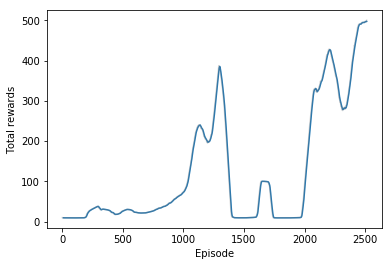

In [32]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

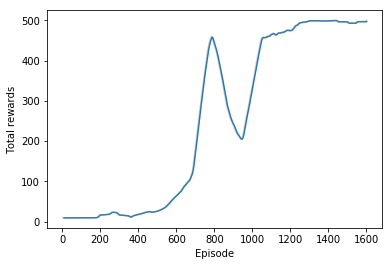

In [28]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

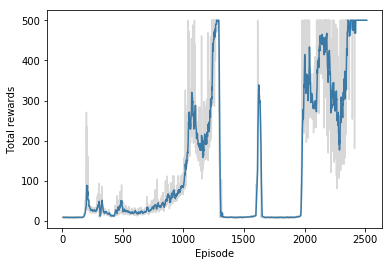

In [33]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

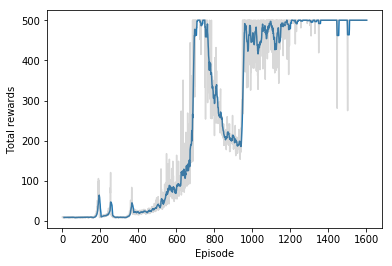

In [30]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

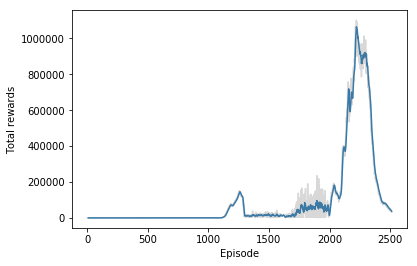

In [34]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

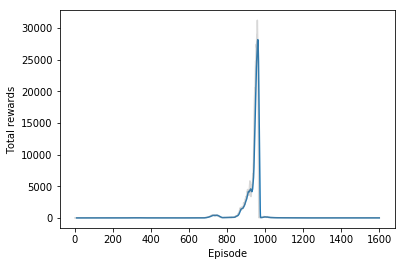

In [31]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

## Testing

Let's checkout how our trained agent plays the game.

In [35]:
# Creating a gym env
import gym

# env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            
            action, _ = act(sess, state)
            
            state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))

# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.